In [87]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
#from tensorflow import keras
import os
from os.path import join, exists

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical, plot_model

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anastasia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
#drop NA values and check if it's a string
df = pd.read_csv('../full_photo_reviews_dc_shuf.csv', header=None,  names=['URL', 'Name', 'Title', 'Review'])
df.dropna(subset=['Name'], inplace=True)
df.dropna(subset=['Title'], inplace=True)
df.dropna(subset=['Review'], inplace=True)
df = df[df['Name'].apply(lambda x: x != "" and isinstance(x, str) )]
df = df[df['Title'].apply(lambda x: x != "" and isinstance(x, str) )]
df = df[df['Review'].apply(lambda x: x != "" and isinstance(x, str) )]
df

,URL,Name,Title,Review
0,https://www.tripadvisor.com/Hotel_Review-g2897...,Sofitel Washington DC,An extraordinary stay,My first time in Washington DC for a business ...
1,https://www.tripadvisor.com/Hotel_Review-g2897...,W Washington D.C.,The W gets an F,The location of the hotel makes it perfect for...
2,https://www.tripadvisor.com/Hotel_Review-g2897...,Tabard Inn,Food!,We were staying next door to the Tabard and de...
3,https://www.tripadvisor.com/Hotel_Review-g2897...,No name,Top-notch!,This hotel was perfect right from the pre-arri...
4,https://www.tripadvisor.com/Hotel_Review-g2897...,Willard InterContinental Washington,Convenient and luxurious,From the moment we stepped into The Willard to...
5,https://www.tripadvisor.com/Hotel_Review-g2897...,Kimpton Hotel Palomar Washington DC,"Great hotel, excellent location, AMAZING STAFF!!",Excellent service and friendly staff did not h...
6,https://www.tripadvisor.com/Hotel_Review-g2897...,Arc The. Hotel,Good location and nice staffs,Had a great 3 night stay at The George Washing...
7,https://www.tripadvisor.com/Hotel_Review-g2897...,"The Jefferson, Washington DC","Both gorgeous and charming, and a wonderful st...",The new lobby is simply stunning. We loved the...
8,https://www.tripadvisor.com/Hotel_Review-g2897...,Arc The. Hotel,A good choice,It is a short walk away from subway and large ...
9,https://www.tripadvisor.com/Hotel_Review-g2897...,Grand Hyatt Washington,Over priced hotel,I booked a room about 3 weeks ago for a confer...


In [48]:
#create an id for each hotel based on hotel name for training purposes
nameMap = {}
nameCount = 0
def nameCategory(name):
    global nameCount
    name = name.strip().lower()
    if name not in nameMap:
        nameMap[name] = nameCount
        nameCount += 1
    return nameMap[name]
df['id'] = df['Name'].apply(nameCategory)
df['text'] = df['Title']  + " " + df['Review']

In [49]:
df

,URL,Name,Title,Review,id,text
0,https://www.tripadvisor.com/Hotel_Review-g2897...,Sofitel Washington DC,An extraordinary stay,My first time in Washington DC for a business ...,0,An extraordinary stay My first time in Washing...
1,https://www.tripadvisor.com/Hotel_Review-g2897...,W Washington D.C.,The W gets an F,The location of the hotel makes it perfect for...,1,The W gets an F The location of the hotel make...
2,https://www.tripadvisor.com/Hotel_Review-g2897...,Tabard Inn,Food!,We were staying next door to the Tabard and de...,2,Food! We were staying next door to the Tabard ...
3,https://www.tripadvisor.com/Hotel_Review-g2897...,No name,Top-notch!,This hotel was perfect right from the pre-arri...,3,Top-notch! This hotel was perfect right from t...
4,https://www.tripadvisor.com/Hotel_Review-g2897...,Willard InterContinental Washington,Convenient and luxurious,From the moment we stepped into The Willard to...,4,Convenient and luxurious From the moment we st...
5,https://www.tripadvisor.com/Hotel_Review-g2897...,Kimpton Hotel Palomar Washington DC,"Great hotel, excellent location, AMAZING STAFF!!",Excellent service and friendly staff did not h...,5,"Great hotel, excellent location, AMAZING STAFF..."
6,https://www.tripadvisor.com/Hotel_Review-g2897...,Arc The. Hotel,Good location and nice staffs,Had a great 3 night stay at The George Washing...,6,Good location and nice staffs Had a great 3 ni...
7,https://www.tripadvisor.com/Hotel_Review-g2897...,"The Jefferson, Washington DC","Both gorgeous and charming, and a wonderful st...",The new lobby is simply stunning. We loved the...,7,"Both gorgeous and charming, and a wonderful st..."
8,https://www.tripadvisor.com/Hotel_Review-g2897...,Arc The. Hotel,A good choice,It is a short walk away from subway and large ...,6,A good choice It is a short walk away from sub...
9,https://www.tripadvisor.com/Hotel_Review-g2897...,Grand Hyatt Washington,Over priced hotel,I booked a room about 3 weeks ago for a confer...,8,Over priced hotel I booked a room about 3 week...


In [8]:
df['Name'].describe()


count        7446
unique        135
top       No name
freq          323
Name: Name, dtype: object

In [50]:
#remove all with No Name
df = df[df['Name'] != 'No name']

In [51]:
df['Name'].describe()

count                    7123
unique                    134
top       Omni Shoreham Hotel
freq                      288
Name: Name, dtype: object

In [52]:
df['id'].describe()

count    7123.000000
mean       39.091113
std        27.913182
min         0.000000
25%        18.000000
50%        33.000000
75%        59.000000
max       134.000000
Name: id, dtype: float64

In [115]:
def clean_text(text):
    # not isinstance(text, basestring) 
    #if text is None or isinstance(text, int) or isinstance(text, float):
    #    return ""
    ## Remove puncuation
    text = unicode(text, "utf-8")
    try:
        text = text.translate(string.punctuation)
    except:
        print(text)
    
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [116]:
#df['text'] = df['text'].map(lambda x: clean_text(x))

Service is
good We are the first time visiting DC and have breakfast in Westin DC City Center. Alem from MZ restaurant at provided us the perfect services. She gave us a warm smell for starting the day. We enjoyed it.


In [8]:
# Load embedings
data_folder = './'
glove_filename = os.path.join(data_folder, 'glove.840B.300d.txt')

embeddings = {}

print('Extract %s' % glove_filename)
with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))

Extract ./glove.840B.300d.txt
Embeddings size: 2196016


In [53]:
### Create sequence
#Embedding -- pre-trained word vectors -- to get context
NUM_WORDS = len(embeddings)

#vocabulary_size = 10000
reviews = df['text']
tokenizer = Tokenizer(num_words = NUM_WORDS)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))


Found 24110 unique tokens.


In [54]:
words_len = min(NUM_WORDS, len(word_index))
embedding_dim = 300
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1

In [55]:
from collections import defaultdict

#count number of symbols
max_word_count_text = 0
text_count = defaultdict(int)

for sentence in reviews:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1

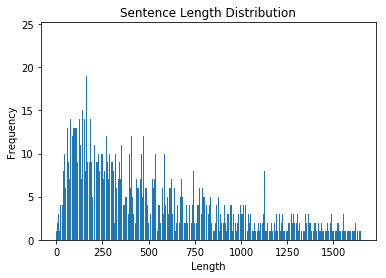

In [153]:
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())

plt.title("Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [154]:
print('Max word text: %d' % max_word_count_text)

Max word text: 10302


In [56]:
#maxlen = 100
max_seq_length = 20
data = pad_sequences(sequences, maxlen = max_seq_length)

In [90]:
#labels = np.array(df['id'])
labels = to_categorical(np.asarray(df['id']))
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (7123, 135)


In [101]:
labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [92]:
# take 10% to test data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)

In [91]:

model = Sequential()
#model.add(Embedding(vocabulary_size, 100, input_length=maxlen))
model.add(Embedding(words_len + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = max_seq_length,
                     trainable = False,
                     name = 'embedding'))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(135, dropout=0.2)) #, recurrent_dropout=0.2))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(135, activation='relu'))
model.add(Dense(135, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
# take 22% to validation from train set
history = model.fit(X_train, y_train, validation_split=0.20, epochs=10)
#history = model.fit(data, labels, validation_split=0.20, epochs=10)

Train on 5128 samples, validate on 1282 samples
Epoch 1/10
5128/5128 [==============================] - 27s 5ms/step - loss: 0.0891 - acc: 0.9747 - val_loss: 0.0398 - val_acc: 0.9926
Epoch 2/10
5128/5128 [==============================] - 25s 5ms/step - loss: 0.0402 - acc: 0.9926 - val_loss: 0.0399 - val_acc: 0.9926
Epoch 3/10
5128/5128 [==============================] - 25s 5ms/step - loss: 0.0402 - acc: 0.9926 - val_loss: 0.0400 - val_acc: 0.9926
Epoch 4/10
5128/5128 [==============================] - 25s 5ms/step - loss: 0.0400 - acc: 0.9926 - val_loss: 0.0397 - val_acc: 0.9926
Epoch 5/10
5128/5128 [==============================] - 25s 5ms/step - loss: 0.0399 - acc: 0.9926 - val_loss: 0.0401 - val_acc: 0.9926
Epoch 6/10
5128/5128 [==============================] - 25s 5ms/step - loss: 0.0398 - acc: 0.9926 - val_loss: 0.0397 - val_acc: 0.9926
Epoch 7/10
5128/5128 [==============================] - 25s 5ms/step - loss: 0.0397 - acc: 0.9926 - val_loss: 0.0400 - val_acc: 0.9926
Epoch 8

In [94]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [97]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

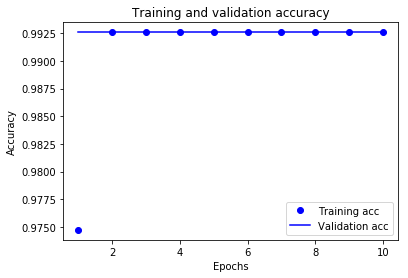

In [98]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [109]:
# Test data

loss, accuracy = model.evaluate(X_test, y_test)
print('loss     = ', loss)
print('accuracy = ', accuracy)

713/713 [==============================] - 1s 2ms/step
loss     =  0.04031151606274186
accuracy =  0.9925925731658936


In [110]:
#labels = np.array(labels)
ynew = model.predict_classes(data)
correctFrame = pd.DataFrame(columns = df.columns)
failedFrame = pd.DataFrame(columns = df.columns)
for i in range(len(data)):
    if ynew[i] == df.iloc[i]['id']: # np.argmax(labels[i], axis=0):
        correctFrame = correctFrame.append(df.iloc[i], ignore_index=True)
    else:
        failedFrame = failedFrame.append(df.iloc[i], ignore_index=True)
        #print("X=%s, Predicted=%s" % (data[i], labels[i]))
        #print("Predicted %d" % (labels[i]))
        #print(df.iloc[i]["Name"])
        #print(df.iloc[i].text)
        #print("")

In [103]:
ynew[0]

4

In [111]:
correctFrame

,URL,Name,Title,Review,id,text
0,https://www.tripadvisor.com/Hotel_Review-g2897...,Willard InterContinental Washington,Convenient and luxurious,From the moment we stepped into The Willard to...,4,Convenient and luxurious From the moment we st...
1,https://www.tripadvisor.com/Hotel_Review-g2897...,Willard InterContinental Washington,Best staff and service! And love the bedding a...,The service here was awful! It felt like they ...,4,Best staff and service! And love the bedding a...
2,https://www.tripadvisor.com/Hotel_Review-g2897...,Willard InterContinental Washington,"Excellent, historic hotel.",It was a good hotel choice. We really enjoyed ...,4,"Excellent, historic hotel. It was a good hotel..."
3,https://www.tripadvisor.com/Hotel_Review-g2897...,Sofitel Washington DC,Great stay in the Financial District,Not nearly as nice as the New York Sofitel. Di...,0,Great stay in the Financial District Not nearl...
4,https://www.tripadvisor.com/Hotel_Review-g2897...,Willard InterContinental Washington,"Attractive, historic hotel but attention to de...","Keep in mind, this hotel was originally built ...",4,"Attractive, historic hotel but attention to de..."
5,https://www.tripadvisor.com/Hotel_Review-g2897...,Willard InterContinental Washington,They saw me coming,Efficient check in and luggage promptly delive...,4,They saw me coming Efficient check in and lugg...
6,https://www.tripadvisor.com/Hotel_Review-g2897...,Willard InterContinental Washington,"Historical, great service but old",A beautiful hotel in a terrific location. Walk...,4,"Historical, great service but old A beautiful ..."
7,https://www.tripadvisor.com/Hotel_Review-g2897...,Willard InterContinental Washington,Good location but more of a business hotel tha...,I took my sister here for an overnight stay fo...,4,Good location but more of a business hotel tha...
8,https://www.tripadvisor.com/Hotel_Review-g2897...,Willard InterContinental Washington,"Perfect service, nice rooms",The location is great in DC for sightseeing.Ni...,4,"Perfect service, nice rooms The location is gr..."
9,https://www.tripadvisor.com/Hotel_Review-g2897...,Willard InterContinental Washington,dated,"This is such a lovell hotel to stay at, with g...",4,"dated This is such a lovell hotel to stay at, ..."


In [112]:
correctFrame['id'].describe()

count     314
unique     11
top         4
freq      222
Name: id, dtype: int64

In [113]:
failedFrame


,URL,Name,Title,Review,id,text
0,https://www.tripadvisor.com/Hotel_Review-g2897...,Sofitel Washington DC,An extraordinary stay,My first time in Washington DC for a business ...,0,An extraordinary stay My first time in Washing...
1,https://www.tripadvisor.com/Hotel_Review-g2897...,W Washington D.C.,The W gets an F,The location of the hotel makes it perfect for...,1,The W gets an F The location of the hotel make...
2,https://www.tripadvisor.com/Hotel_Review-g2897...,Tabard Inn,Food!,We were staying next door to the Tabard and de...,2,Food! We were staying next door to the Tabard ...
3,https://www.tripadvisor.com/Hotel_Review-g2897...,Kimpton Hotel Palomar Washington DC,"Great hotel, excellent location, AMAZING STAFF!!",Excellent service and friendly staff did not h...,5,"Great hotel, excellent location, AMAZING STAFF..."
4,https://www.tripadvisor.com/Hotel_Review-g2897...,Arc The. Hotel,Good location and nice staffs,Had a great 3 night stay at The George Washing...,6,Good location and nice staffs Had a great 3 ni...
5,https://www.tripadvisor.com/Hotel_Review-g2897...,"The Jefferson, Washington DC","Both gorgeous and charming, and a wonderful st...",The new lobby is simply stunning. We loved the...,7,"Both gorgeous and charming, and a wonderful st..."
6,https://www.tripadvisor.com/Hotel_Review-g2897...,Arc The. Hotel,A good choice,It is a short walk away from subway and large ...,6,A good choice It is a short walk away from sub...
7,https://www.tripadvisor.com/Hotel_Review-g2897...,Grand Hyatt Washington,Over priced hotel,I booked a room about 3 weeks ago for a confer...,8,Over priced hotel I booked a room about 3 week...
8,https://www.tripadvisor.com/Hotel_Review-g2897...,Avenue Suites Georgetown,Great place to stay while visiting DC with you...,If you're looking for a place that's centrally...,9,Great place to stay while visiting DC with you...
9,https://www.tripadvisor.com/Hotel_Review-g2897...,"Cambria Hotel Washington, D.C. Convention Center",Decent hotel,We stayed at this hotel based on another famil...,10,Decent hotel We stayed at this hotel based on ...


In [85]:
correctFrame.iloc[3]["URL"]

'https://www.tripadvisor.com/Hotel_Review-g28970-d1456261-Reviews-or515-W_Washington_D_C-Washington_DC_District_of_Columbia.html'

In [86]:
df[df["Title"] == "Solid 4* Hotel with A+ Location"]

,URL,Name,Title,Review,id,text
84,https://www.tripadvisor.com/Hotel_Review-g2897...,W Washington D.C.,Solid 4* Hotel with A+ Location,Pros:o A+ Location if you want to walk to hist...,1,Solid 4* Hotel with A+ Location Pros:o A+ Loca...


In [114]:
failedFrame['id'].describe()

count     6809
unique     134
top         28
freq       282
Name: id, dtype: int64